In [1]:
# Import modules 

from IPython.core.debugger import set_trace
import gc

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.distributions import Categorical, Bernoulli

import copy
import numpy as np

import pandas as pd
from ast import literal_eval
import time

import import_ipynb
from config import *
from environment import *


%load_ext autoreload
%autoreload 2

importing Jupyter notebook from config.ipynb
importing Jupyter notebook from environment.ipynb
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
SEED = 47
torch.manual_seed(SEED)
np.random.seed(SEED) 

In [3]:
config = Config()
config.machine_profile = "small_default"
config.job_profile = "small_default"
config.reconfigure()

file_learn = "datasets/learning_dataset_env_small_default.data"
file_test = "datasets_multiobjective/testing_dataset_env_small_multiobjective_tout3600.data"

In [4]:
#################################################################################################

In [5]:
#-----------------------------------------------------------------------------
# Read datasets
#-----------------------------------------------------------------------------
     

learning_machines = []
learning_duration = []

testing_machines = []
testing_duration = []
testing_solver = []


# Learning dataset
num_lines = len(open(file_learn).readlines())
    
with open(file_learn, "r") as file:
    
    for _ in range(num_lines // (config.num_jobs+1)):
            
        NB_JOBS, NB_MACHINES = [int(v) for v in file.readline().split()]
        JOBS = [[int(v) for v in file.readline().split()] for i in range(NB_JOBS)]

        # Build list of machines. MACHINES[j][s] = id of the machine for the operation s of the job j
        learning_machines.append([[JOBS[j][2 * s] for s in range(NB_MACHINES)] for j in range(NB_JOBS)])

        # Build list of durations. DURATION[j][s] = duration of the operation s of the job j
        learning_duration.append([[JOBS[j][2 * s + 1] for s in range(NB_MACHINES)] for j in range(NB_JOBS)])


learning_machines = np.array(learning_machines)
learning_duration = np.array(learning_duration)

# Testing dataset

num_lines = len(open(file_test).readlines())
    
with open(file_test, "r") as file:
    
    for _ in range(num_lines // (config.num_jobs+2)):
            
        NB_JOBS, NB_MACHINES = [int(v) for v in file.readline().split()]
        JOBS = [[int(v) for v in file.readline().split()] for i in range(NB_JOBS)]
        testing_solver.append(int(file.readline().split()[1]))
        
        # Build list of machines. MACHINES[j][s] = id of the machine for the operation s of the job j
        testing_machines.append([[JOBS[j][2 * s] for s in range(NB_MACHINES)] for j in range(NB_JOBS)])

        # Build list of durations. DURATION[j][s] = duration of the operation s of the job j
        testing_duration.append([[JOBS[j][2 * s + 1] for s in range(NB_MACHINES)] for j in range(NB_JOBS)])
        

testing_machines = np.array(testing_machines)
testing_duration = np.array(testing_duration)
testing_solver = np.array(testing_solver)


In [6]:
device="cuda:0"

In [16]:
def computeTestingError(inference=False):
    
    BSS=10
    LSS=40
    
    placementsBest = []
    
    diffBest = []
    averError = []
    averDiff = []
    
    IterPerEpoch = len(testing_machines)//BSS
    
    with torch.no_grad():
        
        for it in range(IterPerEpoch):
            
            
            machines = testing_machines[it*BSS:(it+1)*BSS]
            machines = np.concatenate([machines for _ in range(LSS)])
            duration = testing_duration[it*BSS:(it+1)*BSS]
            duration = np.concatenate([duration for _ in range(LSS)])

            start_time = time.time()
            rewards, logProbs, probs, actions_bare, actions, jobTime, placements = actor.forward(machines, duration, inference)
            elapsed_time = time.time() - start_time

            # Obtain the solver solution
            cv_ = testing_solver[it*BSS:(it+1)*BSS]
            cv = np.concatenate([cv_ for j in range(LSS)])
            
            # Compute the difference between the model and the solver
            diff = rewards.cpu().data.numpy() - cv
            diffBest.extend(np.min(diff.reshape([LSS,BSS]),0))
            
            if inference:
                idxsBest = np.argmin(diff.reshape([LSS,BSS]),0)
                placements = placements.cpu().data.numpy()
                placements = placements.reshape([LSS,BSS,config.num_machines,config.num_tasksperjob,2])

                for i in range(BSS):
                    placementsBest.append(placements[idxsBest[i],i,:,:,:])


            averDiff.append(np.mean(diff))
            averError.append(np.sum(diff > .01)/BSS)
            set_trace()
 
    return np.mean(averError), np.mean(averDiff), diffBest, placementsBest

In [17]:
computeTestingError()

> <ipython-input-16-3ba29251c611>(16)computeTestingError()
     14     with torch.no_grad():
     15 
---> 16         for it in range(IterPerEpoch):
     17 
     18 

ipdb> np.mean(cv_)
223.1
ipdb> np.mean(np.array(cv_)+np.array(diffBest))
348.1
ipdb> np.std(cv_)
26.628743868233816
ipdb> np.std(np.array(cv_)+np.array(diffBest))
36.62908680270367
ipdb> exit


BdbQuit: 

In [ ]:
np.mean(cv_)
np.std(cv_)
np.mean(np.array(cv_)+np.array(diffBest))
np.std(np.array(cv_)+np.array(diffBest))

In [8]:
class Actor(nn.Module):
    
    def __init__(self, config):
        
        super(Actor, self).__init__() 
        
        self.config = config
        
        
        self.jobsEmbedding = nn.Linear(2, config.embedding_size,  bias=False)  # 64, 6 
        self.stateEmbedding = nn.Linear(config.num_jobs*2, config.embedding_size,  bias=False)  # xsmall8, small20
        self.encoder = nn.LSTM(input_size= config.embedding_size, hidden_size=config.embedding_size, num_layers= 1, batch_first=True)
        
        
        self.activation = F.relu
        
        self.fc1 = nn.Linear(config.embedding_size*(config.num_jobs+1), 128, bias=True)
        self.fc2 = nn.Linear(512, 128, bias=True)  # Layer used in: medium, large and xlarge
        self.fc3 = nn.Linear(128, config.num_jobs*2, bias=True) 
        
        #nn.init.xavier_normal(self.fc1.weight)
       
    
    def forward(self, machines, duration, inference=False):
        

        BS = machines.shape[0]
        
        machines = np.append(machines, np.zeros((BS, self.config.num_jobs, 1)), axis=2)
        duration = np.append(duration, np.zeros((BS, self.config.num_jobs, 1)), axis=2)
        

        assert self.config.num_jobs == machines.shape[1]
        assert self.config.num_tasksperjob +1 == machines.shape[2] 

        
        self.machines = torch.Tensor(machines).to(device)
        self.duration = torch.Tensor(duration).to(device)
        self.jobs = torch.stack((self.machines, self.duration), dim = 3) # [batch, jobs, machines, 2]
        
        
        #-----------------------------------------------------------------------------
        # Jobs embedding using the same LSTM
        #-----------------------------------------------------------------------------
        
        embeddedJobs = self.jobsEmbedding(self.jobs) # [batch, jobs, machines, embeddings]
        
        serializedJobs = torch.unbind(embeddedJobs, dim=1) # list of [batch, machines, embeddings] for each job
     
        outputJobs = [[] for _ in range(self.config.num_jobs)]   
        
        
        for i in range(self.config.num_jobs):
        
            h = torch.zeros([1, BS, config.embedding_size], device=device)
            c = torch.zeros([1, BS, config.embedding_size], device=device)

            outputs = []
            outputsh = []
            outputsc = []

            for j in range(self.config.num_tasksperjob-1, -1, -1):
                
                output, (h , c ) = self.encoder(serializedJobs[i][:,j:j+1,:], (h , c ))
                outputs.insert(0,output.squeeze(1))
                outputsh.insert(0,h.squeeze(0))
                outputsc.insert(0,c.squeeze(0))
                
            outputJobs[i] =  outputsh
            
        # Add a last task embedded as zeros for every job
        
        emptyEmbeddings = torch.zeros([BS, self.config.embedding_size], device=device)
        [job.append(emptyEmbeddings) for job in outputJobs]                                           # [jobs, tasks+1] -> [batch, embedding]
        
        outputJobs = torch.stack([torch.stack(job, dim=1) for job in outputJobs], dim=1).to(device)   # [batch, jobs, tasks+1, embedding]
        
        
        #-----------------------------------------------------------------------------
        # Iteration with the environment
        #-----------------------------------------------------------------------------
        
        actions = []
        actions_bare = []
        probs = []
        logProbs = []
        gap_counters = []
        
        
        indexes = torch.zeros([BS, self.config.num_jobs], device=device, dtype=torch.long)
        mask = torch.ones([BS, self.config.num_jobs], device=device, dtype=torch.long)
        maxTasks = torch.ones([BS, self.config.num_jobs], device=device, dtype=torch.long) * self.config.num_tasksperjob
        
        # State 0: remaining time for the machine where i should place the task to be free
        state0 = torch.zeros([BS, self.config.num_jobs], device=device)
        state0T = torch.t(state0)
        
        # State 1: remaining time for the previous task to end
        state1 = torch.zeros([BS, self.config.num_jobs], device=device)
        
        # Remaining time in each machine
        machineTime = torch.zeros([BS, self.config.num_machines], device=device, dtype=torch.float)  # [batch. machines]
        
        # Remaining time of the prevous task to end = state 1
        previousTaskTime = torch.zeros([BS, self.config.num_jobs], device=device, dtype=torch.long)  # [batch, jobs]
        
        # Makespan is the largest of the job times
        jobTime = torch.zeros([BS, self.config.num_jobs], device=device, dtype=torch.long)# [batch, jobs]
        
        # Action correction variables
        tmp = torch.zeros([BS, self.config.num_machines], device=device)
        tmp2 = torch.zeros([BS, self.config.num_jobs],  device=device, dtype=torch.long)
        tmp2T = torch.t(tmp2)
        
        
        # Placements
        placements0 = torch.zeros([BS, self.config.num_machines, self.config.num_tasksperjob+1], device=device, dtype=torch.float)
        placements1 = torch.zeros([BS, self.config.num_machines, self.config.num_tasksperjob+1], device=device, dtype=torch.float)
        
        placements = torch.stack([placements0[:,:,:-1], placements1[:,:,:-1]], dim=3).int()  
        
        indx_placements = torch.zeros([BS, self.config.num_machines], device=device, dtype=torch.long)
        
        # Gap counter
        ready_count = torch.zeros([BS, self.config.num_machines], device=device, dtype=torch.long)
        gap_counter = torch.zeros([BS, self.config.num_machines], device=device, dtype=torch.long)
        machine_counter = torch.zeros([BS, self.config.num_machines], device=device, dtype=torch.float)
        
        #-----------------------------------------------------------------------------
        # Allocation loop, while every task has been placed, binary decissions 0/1
        #-----------------------------------------------------------------------------

        lastOutputJobs = outputJobs[:,:,-1,:]
        lastOutputJobs = torch.flatten(lastOutputJobs, start_dim=1)
        
        while ~torch.all(maxTasks - indexes == 0):   
            
            indexes_ = torch.unsqueeze(indexes, -1)
            indexes_ = torch.unsqueeze(indexes_, -1)
            indexes_ = indexes_.expand(-1,-1,-1,self.config.embedding_size)
            tasks2place = torch.gather(outputJobs, 2, indexes_).squeeze(2)    # [batch, jobs, embeddings]
            

            tasks2place = torch.flatten(tasks2place, start_dim=1)
            
            
            indexes_ = torch.unsqueeze(indexes, -1)
            machinesGather = torch.gather(self.machines, 2, indexes_).squeeze(2).long()       # [batch, job]
            durationGather = torch.gather(self.duration, 2, indexes_).squeeze(2).long()       # [batch, job]
            
            state = torch.stack([state0/10.0, state1/10.0], dim=2)
            state = torch.flatten(state, start_dim=1)

            # State Embedding
            embeddedState = self.stateEmbedding(state) # [batch, jobs, embeddings]
            
            # Concatenation to create the input to the model
            jobsAndStates = torch.cat([tasks2place, embeddedState], 1)    

            # Decoder DNN
            out = self.fc1(jobsAndStates)
            out = self.fc3(out)            
            out = out.view(BS,-1, 2)
            
            # Output distribution
            m = Categorical(logits=out)
            
            prob = m.probs
            entropy = m.entropy()
            action_bare = m.sample().long()
            log_prob = m.log_prob(action_bare)
            
            # Mask avoiding to place in machines that are working or place before the previous task ends.
            action = action_bare * mask

            ##################################################################
            # Action correction: if two tasks that belong to the same machine are 
            # intended to be placed, only the first one is scheduled.
            
            tmp[:,:] = 0
            tmp2[:,:] = 0
            
            for actionT_, machinesGatherT_ in zip(torch.t(action), torch.t(machinesGather)):
                tmp.index_put_([torch.tensor(range(BS), device=device), machinesGatherT_], actionT_.float(),  accumulate=True)
            
            for i, (machinesGatherT_, actionT_) in enumerate(zip(torch.t(machinesGather),torch.t(action))):
                
                tmp[range(BS), machinesGatherT_] = tmp[range(BS), machinesGatherT_] - actionT_
                
                w = (tmp[range(BS), machinesGatherT_] == 0) & (actionT_[range(BS)] == 1)
                tmp2T[i] = w.float()

            
            action = tmp2
            
            ####################################################################
            # Update placements
            if inference:
                for action_, machinesGather_, placements0_, placements1_, indx_placements_, indexes_ in zip(action, machinesGather, placements0, placements1, indx_placements, indexes):

                    placements0_.index_put_([machinesGather_, indx_placements_[machinesGather_]], torch.tensor(range(self.config.num_machines),  device=device, dtype=torch.float) * action_.float(),  accumulate=True)
                    placements1_.index_put_([machinesGather_, indx_placements_[machinesGather_]], indexes_ * action_.float(),  accumulate=True)

                    indx_placements_.put_(machinesGather_, action_,  accumulate=True)

                placements = torch.stack([placements0[:,:,:-1], placements1[:,:,:-1]], dim=3).int()   
            
            
            ####################################################################
            # Update state
            
            durationGather = durationGather * action.long()      # [batch, job]
            tmp3 = durationGather.bool().long()
                        
            for machinesGatherT_, durationGatherT_ , tmp3 in zip(torch.t(machinesGather), torch.t(durationGather), torch.t(tmp3)):
                machineTime.index_put_([torch.arange(BS, device=device), machinesGatherT_], durationGatherT_.float(),  accumulate=True)
                machine_counter.index_put_([torch.arange(BS, device=device), machinesGatherT_], tmp3.float(),  accumulate=True)
            
            previousTaskTime = previousTaskTime + durationGather
            
            # Update the index of the next tasks to be placed
            indexes = indexes + action
            
            # Update gaps
            
            gap_counter = gap_counter + (~machineTime.bool() & (machine_counter.long() != 0) &(machine_counter.long() != self.config.num_tasksperjob)).long()
            
            
            # Update total time       
            jobTime = jobTime + (~(indexes == self.config.num_tasksperjob)).int()
            
            # Time pases one unit
            previousTaskTime = torch.max(previousTaskTime-1 , torch.zeros([BS, self.config.num_jobs], device=device, dtype=torch.long))
            machineTime = torch.max(machineTime-1 , torch.zeros([BS, self.config.num_machines], device=device))
            

            # Update state
            indexes_ = torch.unsqueeze(indexes, -1)
            
            machinesGather = torch.gather(self.machines, 2, indexes_).squeeze(2).long()               # [batch, job]

   
            for i, (machinesGatherT_, machineTimeT_)  in enumerate(zip(torch.t(machinesGather), torch.t(machineTime))):
                state0T[i] = machineTime[range(BS), machinesGatherT_]


            state1 = previousTaskTime.float()
            
            # Mask to avoid place in machines that are working or place before the previous task ends.
            mask = (~(state0.bool() | state1.bool()) & (indexes != self.config.num_tasksperjob)).int()
            

            # Append
            actions.append(copy.deepcopy(action))
            actions_bare.append(action_bare)
            probs.append(prob)
            logProbs.append(log_prob)
            gap_counters.append(copy.deepcopy(gap_counter))
            

        # Stack
        logProbs = torch.stack(logProbs)
        actions = torch.stack(actions)
        actions_bare = torch.stack(actions_bare)
        probs = torch.stack(probs)
        gap_counters = torch.stack(gap_counters)
        
        # Mask probs after last decision
        mask2 = torch.zeros(actions.shape[0], BS, self.config.num_jobs, device=device)
        for i in range(BS):
            for j in range(self.config.num_jobs):
                
                mask2[0:jobTime[i,j]+1,i,j] = 1
        
        logProbs = logProbs * mask2
        
        
        # Adjust jobTime adding last task
        jobTime = jobTime + self.duration[:,:,-2].long()
        
        rewards = torch.max(jobTime, dim=1).values
        
        obj = rewards + torch.sum(gap_counter, axis=1)

        return obj, logProbs, probs, actions_bare, actions, jobTime, placements
        

In [9]:
actor = Actor(config).to(device)

In [10]:
rewards, logProbs, probs, actions_bare, actions, jobTime, placements = actor.forward(testing_machines, testing_duration, inference=True)

In [11]:
#################################################################################################

In [12]:
# Learning process

lr=0.0005

BS=20
LS=40

IterPerEpoch = len(learning_machines)//BS

actor = Actor(config).to(device)  
actor_optim = optim.Adam(actor.parameters(), lr=lr)

allSamples=[i for i in range(len(learning_machines))]

#gamma = np.float_power(1e-1,1/200.0)
#scheduler = torch.optim.lr_scheduler.StepLR(actor_optim, len(allSamples)//BS, gamma=gamma, last_epoch=-1)

TESTING_AvgError=[]
TESTING_AvgDiff=[]

------------ 0 : 2.69s
loss:  tensor(134989.6250, device='cuda:0')
RVV:  tensor(5.2650, device='cuda:0')
logProp:  tensor(-578.0281, device='cuda:0')
DiffBest:  216.1


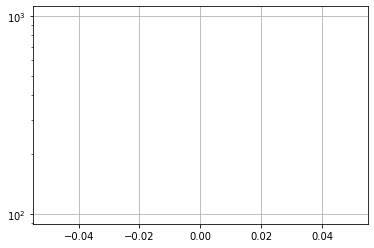

------------ 10 : 2.97s
loss:  tensor(109182.0312, device='cuda:0')
RVV:  tensor(4.8538, device='cuda:0')
logProp:  tensor(-518.2888, device='cuda:0')
------------ 20 : 2.72s
loss:  tensor(64696.5469, device='cuda:0')
RVV:  tensor(4.6297, device='cuda:0')
logProp:  tensor(-331.9431, device='cuda:0')
------------ 30 : 2.72s
loss:  tensor(54301.0586, device='cuda:0')
RVV:  tensor(4.6968, device='cuda:0')
logProp:  tensor(-261.3294, device='cuda:0')
------------ 40 : 2.66s
loss:  tensor(58128.8594, device='cuda:0')
RVV:  tensor(4.4749, device='cuda:0')
logProp:  tensor(-262.4006, device='cuda:0')
------------ 50 : 2.75s
loss:  tensor(40532.4531, device='cuda:0')
RVV:  tensor(4.5235, device='cuda:0')
logProp:  tensor(-247.8314, device='cuda:0')
DiffBest:  143.7


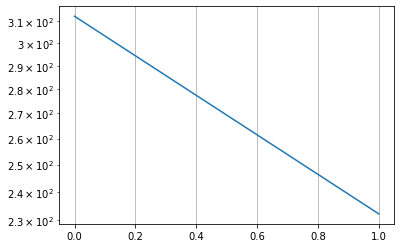

------------ 60 : 2.91s
loss:  tensor(42702.1641, device='cuda:0')
RVV:  tensor(4.6627, device='cuda:0')
logProp:  tensor(-239.3767, device='cuda:0')
------------ 70 : 2.74s
loss:  tensor(46504.2227, device='cuda:0')
RVV:  tensor(4.7775, device='cuda:0')
logProp:  tensor(-226.3559, device='cuda:0')
------------ 80 : 2.76s
loss:  tensor(39119.7852, device='cuda:0')
RVV:  tensor(4.6003, device='cuda:0')
logProp:  tensor(-224.8056, device='cuda:0')
------------ 90 : 2.81s
loss:  tensor(36701.7656, device='cuda:0')
RVV:  tensor(4.4599, device='cuda:0')
logProp:  tensor(-223.9249, device='cuda:0')
------------ 100 : 2.61s
loss:  tensor(45780.2148, device='cuda:0')
RVV:  tensor(4.6122, device='cuda:0')
logProp:  tensor(-217.9854, device='cuda:0')
DiffBest:  150.3


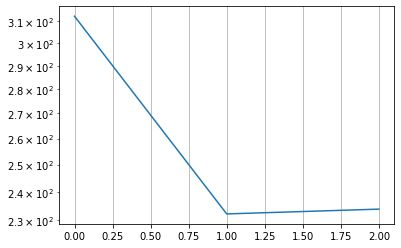

------------ 110 : 2.86s
loss:  tensor(34222.8906, device='cuda:0')
RVV:  tensor(4.3621, device='cuda:0')
logProp:  tensor(-203.0004, device='cuda:0')
------------ 120 : 2.73s
loss:  tensor(45699.2188, device='cuda:0')
RVV:  tensor(4.3675, device='cuda:0')
logProp:  tensor(-218.7088, device='cuda:0')
------------ 130 : 2.57s
loss:  tensor(40455.0781, device='cuda:0')
RVV:  tensor(4.6293, device='cuda:0')
logProp:  tensor(-212.7995, device='cuda:0')
------------ 140 : 2.66s
loss:  tensor(37958.8477, device='cuda:0')
RVV:  tensor(4.3969, device='cuda:0')
logProp:  tensor(-199.6595, device='cuda:0')
------------ 150 : 2.50s
loss:  tensor(36127.6758, device='cuda:0')
RVV:  tensor(4.5050, device='cuda:0')
logProp:  tensor(-184.1776, device='cuda:0')
DiffBest:  150.8


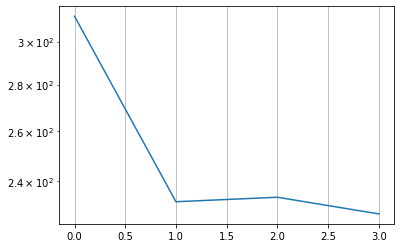

------------ 160 : 2.51s
loss:  tensor(29277.4551, device='cuda:0')
RVV:  tensor(4.4678, device='cuda:0')
logProp:  tensor(-147.8716, device='cuda:0')
------------ 170 : 2.40s
loss:  tensor(28957.7266, device='cuda:0')
RVV:  tensor(4.4524, device='cuda:0')
logProp:  tensor(-175.0550, device='cuda:0')
------------ 180 : 2.45s
loss:  tensor(28792.7324, device='cuda:0')
RVV:  tensor(4.4267, device='cuda:0')
logProp:  tensor(-170.0200, device='cuda:0')
------------ 190 : 3.10s
loss:  tensor(40479.9141, device='cuda:0')
RVV:  tensor(4.5317, device='cuda:0')
logProp:  tensor(-220.9147, device='cuda:0')
------------ 200 : 2.52s
loss:  tensor(45986.1523, device='cuda:0')
RVV:  tensor(4.5774, device='cuda:0')
logProp:  tensor(-233.8984, device='cuda:0')
DiffBest:  142.2


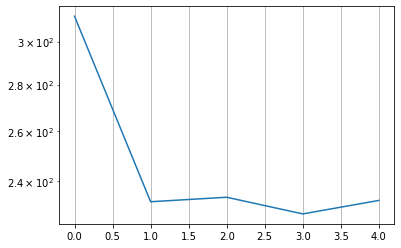

------------ 210 : 2.63s
loss:  tensor(48839.5586, device='cuda:0')
RVV:  tensor(4.4355, device='cuda:0')
logProp:  tensor(-249.9469, device='cuda:0')
------------ 220 : 2.68s
loss:  tensor(40742.2266, device='cuda:0')
RVV:  tensor(4.4514, device='cuda:0')
logProp:  tensor(-225.6864, device='cuda:0')
------------ 230 : 2.82s
loss:  tensor(38362.9375, device='cuda:0')
RVV:  tensor(4.6719, device='cuda:0')
logProp:  tensor(-213.0829, device='cuda:0')
------------ 240 : 2.63s
loss:  tensor(34287.3438, device='cuda:0')
RVV:  tensor(4.3911, device='cuda:0')
logProp:  tensor(-206.0543, device='cuda:0')
------------ 250 : 2.70s
loss:  tensor(41350.8633, device='cuda:0')
RVV:  tensor(4.5932, device='cuda:0')
logProp:  tensor(-200.4103, device='cuda:0')
DiffBest:  135.4


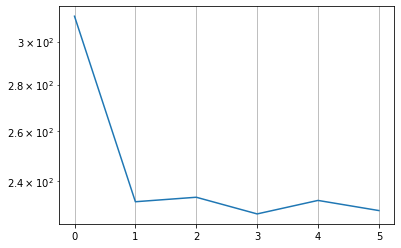

------------ 260 : 2.76s
loss:  tensor(39294.4180, device='cuda:0')
RVV:  tensor(4.4417, device='cuda:0')
logProp:  tensor(-225.2849, device='cuda:0')
------------ 270 : 2.61s
loss:  tensor(42844.4297, device='cuda:0')
RVV:  tensor(4.3490, device='cuda:0')
logProp:  tensor(-222.1052, device='cuda:0')
------------ 280 : 2.75s
loss:  tensor(42564.9375, device='cuda:0')
RVV:  tensor(4.7374, device='cuda:0')
logProp:  tensor(-200.9329, device='cuda:0')
------------ 290 : 2.71s
loss:  tensor(25936.8848, device='cuda:0')
RVV:  tensor(4.5230, device='cuda:0')
logProp:  tensor(-145.1484, device='cuda:0')
------------ 300 : 2.77s
loss:  tensor(25605.1836, device='cuda:0')
RVV:  tensor(4.5667, device='cuda:0')
logProp:  tensor(-136.3983, device='cuda:0')
DiffBest:  141.2


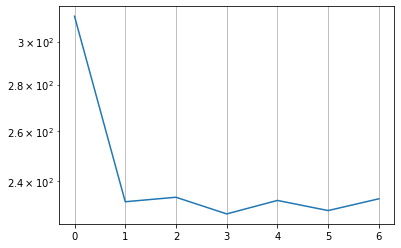

------------ 310 : 2.52s
loss:  tensor(34503.9531, device='cuda:0')
RVV:  tensor(4.4895, device='cuda:0')
logProp:  tensor(-183.5331, device='cuda:0')
------------ 320 : 2.67s
loss:  tensor(36974.1641, device='cuda:0')
RVV:  tensor(4.4398, device='cuda:0')
logProp:  tensor(-180.4980, device='cuda:0')
------------ 330 : 2.65s
loss:  tensor(35311.3125, device='cuda:0')
RVV:  tensor(4.6484, device='cuda:0')
logProp:  tensor(-208.1388, device='cuda:0')
------------ 340 : 2.83s
loss:  tensor(27333.6035, device='cuda:0')
RVV:  tensor(4.3530, device='cuda:0')
logProp:  tensor(-164.1443, device='cuda:0')
------------ 350 : 2.60s
loss:  tensor(25087.5137, device='cuda:0')
RVV:  tensor(4.3094, device='cuda:0')
logProp:  tensor(-154.0005, device='cuda:0')
DiffBest:  145.9


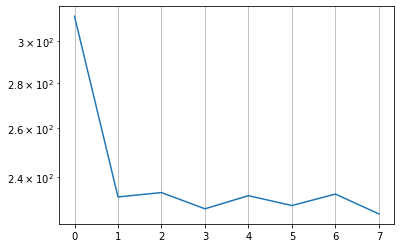

------------ 360 : 2.62s
loss:  tensor(29206.4297, device='cuda:0')
RVV:  tensor(4.4981, device='cuda:0')
logProp:  tensor(-179.7205, device='cuda:0')
------------ 370 : 2.76s
loss:  tensor(19211.8164, device='cuda:0')
RVV:  tensor(4.3798, device='cuda:0')
logProp:  tensor(-139.4528, device='cuda:0')
------------ 380 : 2.87s
loss:  tensor(21763.6387, device='cuda:0')
RVV:  tensor(4.5360, device='cuda:0')
logProp:  tensor(-122.6779, device='cuda:0')
------------ 390 : 2.83s
loss:  tensor(24136.3887, device='cuda:0')
RVV:  tensor(4.5357, device='cuda:0')
logProp:  tensor(-138.6628, device='cuda:0')
------------ 400 : 2.76s
loss:  tensor(24992.8223, device='cuda:0')
RVV:  tensor(4.4335, device='cuda:0')
logProp:  tensor(-132.4568, device='cuda:0')
DiffBest:  144.0


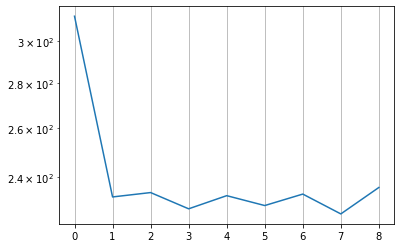

------------ 410 : 2.59s
loss:  tensor(30128.0840, device='cuda:0')
RVV:  tensor(4.6206, device='cuda:0')
logProp:  tensor(-141.3996, device='cuda:0')
------------ 420 : 2.77s
loss:  tensor(19513.7598, device='cuda:0')
RVV:  tensor(4.4510, device='cuda:0')
logProp:  tensor(-109.5084, device='cuda:0')
------------ 430 : 2.58s
loss:  tensor(28604.4141, device='cuda:0')
RVV:  tensor(4.4219, device='cuda:0')
logProp:  tensor(-148.0788, device='cuda:0')
------------ 440 : 2.70s
loss:  tensor(34998.6523, device='cuda:0')
RVV:  tensor(4.5252, device='cuda:0')
logProp:  tensor(-184.4372, device='cuda:0')
------------ 450 : 2.70s
loss:  tensor(31564.0977, device='cuda:0')
RVV:  tensor(4.7982, device='cuda:0')
logProp:  tensor(-154.7155, device='cuda:0')
DiffBest:  144.5


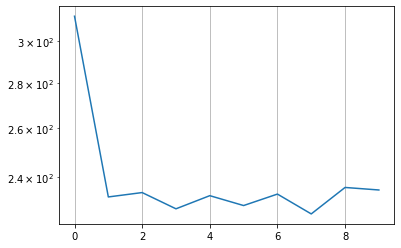

------------ 460 : 2.66s
loss:  tensor(26625.4023, device='cuda:0')
RVV:  tensor(4.6591, device='cuda:0')
logProp:  tensor(-141.9005, device='cuda:0')
------------ 470 : 2.61s
loss:  tensor(18177.7168, device='cuda:0')
RVV:  tensor(4.4361, device='cuda:0')
logProp:  tensor(-125.9698, device='cuda:0')
------------ 480 : 2.61s
loss:  tensor(29994.3574, device='cuda:0')
RVV:  tensor(4.4336, device='cuda:0')
logProp:  tensor(-166.0335, device='cuda:0')
------------ 490 : 2.51s
loss:  tensor(29670.8438, device='cuda:0')
RVV:  tensor(4.4981, device='cuda:0')
logProp:  tensor(-170.4018, device='cuda:0')
------------ 0 : 2.67s
loss:  tensor(23453.0488, device='cuda:0')
RVV:  tensor(4.4100, device='cuda:0')
logProp:  tensor(-128.2989, device='cuda:0')
DiffBest:  138.0


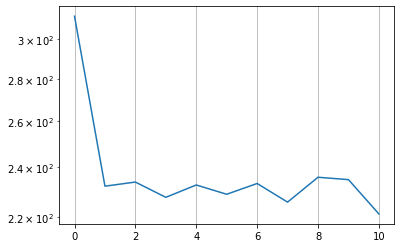

------------ 10 : 2.67s
loss:  tensor(32486.7441, device='cuda:0')
RVV:  tensor(4.3443, device='cuda:0')
logProp:  tensor(-180.8733, device='cuda:0')
------------ 20 : 2.53s
loss:  tensor(50151.6797, device='cuda:0')
RVV:  tensor(4.4338, device='cuda:0')
logProp:  tensor(-256.0278, device='cuda:0')
------------ 30 : 3.00s
loss:  tensor(33448.1016, device='cuda:0')
RVV:  tensor(4.4177, device='cuda:0')
logProp:  tensor(-176.3913, device='cuda:0')
------------ 40 : 2.78s
loss:  tensor(34583.5195, device='cuda:0')
RVV:  tensor(4.5291, device='cuda:0')
logProp:  tensor(-176.6370, device='cuda:0')
------------ 50 : 2.90s
loss:  tensor(30494.6035, device='cuda:0')
RVV:  tensor(4.5120, device='cuda:0')
logProp:  tensor(-158.2714, device='cuda:0')
DiffBest:  129.5


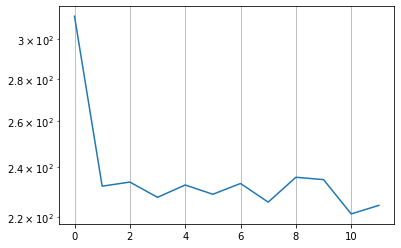

------------ 60 : 2.56s
loss:  tensor(43926.8672, device='cuda:0')
RVV:  tensor(4.5856, device='cuda:0')
logProp:  tensor(-196.1891, device='cuda:0')
------------ 70 : 2.54s
loss:  tensor(42858.6289, device='cuda:0')
RVV:  tensor(4.5781, device='cuda:0')
logProp:  tensor(-205.1892, device='cuda:0')
------------ 80 : 2.51s
loss:  tensor(37966.6758, device='cuda:0')
RVV:  tensor(4.6439, device='cuda:0')
logProp:  tensor(-160.4627, device='cuda:0')
------------ 90 : 2.54s
loss:  tensor(33803.6602, device='cuda:0')
RVV:  tensor(4.5695, device='cuda:0')
logProp:  tensor(-156.3043, device='cuda:0')
------------ 100 : 2.62s
loss:  tensor(32184.7812, device='cuda:0')
RVV:  tensor(4.4838, device='cuda:0')
logProp:  tensor(-157.1736, device='cuda:0')
DiffBest:  135.8


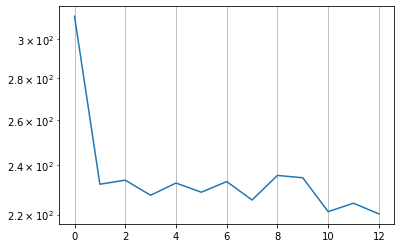

------------ 110 : 2.59s
loss:  tensor(33039.9961, device='cuda:0')
RVV:  tensor(4.6199, device='cuda:0')
logProp:  tensor(-135.6547, device='cuda:0')
------------ 120 : 3.10s
loss:  tensor(19517.4570, device='cuda:0')
RVV:  tensor(4.4812, device='cuda:0')
logProp:  tensor(-121.6557, device='cuda:0')
------------ 130 : 2.96s
loss:  tensor(33147.5000, device='cuda:0')
RVV:  tensor(4.5812, device='cuda:0')
logProp:  tensor(-186.2927, device='cuda:0')
------------ 140 : 2.77s
loss:  tensor(36821.3398, device='cuda:0')
RVV:  tensor(4.4607, device='cuda:0')
logProp:  tensor(-195.5314, device='cuda:0')
------------ 150 : 2.51s
loss:  tensor(37070.2500, device='cuda:0')
RVV:  tensor(4.4416, device='cuda:0')
logProp:  tensor(-198.9429, device='cuda:0')
DiffBest:  134.3


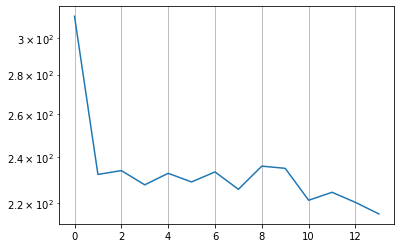

------------ 160 : 2.63s
loss:  tensor(33753.4492, device='cuda:0')
RVV:  tensor(4.4755, device='cuda:0')
logProp:  tensor(-211.1918, device='cuda:0')
------------ 170 : 2.63s
loss:  tensor(28294.8828, device='cuda:0')
RVV:  tensor(4.5926, device='cuda:0')
logProp:  tensor(-157.8676, device='cuda:0')
------------ 180 : 2.70s
loss:  tensor(13929.9775, device='cuda:0')
RVV:  tensor(4.6422, device='cuda:0')
logProp:  tensor(-84.2711, device='cuda:0')
------------ 190 : 2.76s
loss:  tensor(12756.9355, device='cuda:0')
RVV:  tensor(4.5233, device='cuda:0')
logProp:  tensor(-72.5710, device='cuda:0')
------------ 200 : 2.77s
loss:  tensor(18395.2129, device='cuda:0')
RVV:  tensor(4.4550, device='cuda:0')
logProp:  tensor(-109.2444, device='cuda:0')
DiffBest:  142.7


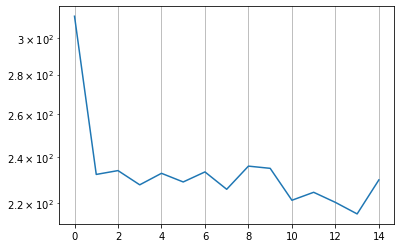

------------ 210 : 2.72s
loss:  tensor(24976.0469, device='cuda:0')
RVV:  tensor(4.5100, device='cuda:0')
logProp:  tensor(-132.7487, device='cuda:0')
------------ 220 : 2.80s
loss:  tensor(24328.0254, device='cuda:0')
RVV:  tensor(4.6329, device='cuda:0')
logProp:  tensor(-121.6991, device='cuda:0')
------------ 230 : 2.46s
loss:  tensor(33454.1133, device='cuda:0')
RVV:  tensor(4.4900, device='cuda:0')
logProp:  tensor(-163.8632, device='cuda:0')
------------ 240 : 2.78s
loss:  tensor(15610.4688, device='cuda:0')
RVV:  tensor(4.3937, device='cuda:0')
logProp:  tensor(-114.8148, device='cuda:0')
------------ 250 : 3.03s
loss:  tensor(27615.4727, device='cuda:0')
RVV:  tensor(4.4299, device='cuda:0')
logProp:  tensor(-149.8112, device='cuda:0')
DiffBest:  132.3


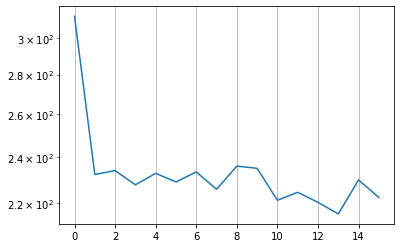

------------ 260 : 2.87s
loss:  tensor(20619.5078, device='cuda:0')
RVV:  tensor(4.3084, device='cuda:0')
logProp:  tensor(-154.4715, device='cuda:0')
------------ 270 : 3.05s
loss:  tensor(27747.0996, device='cuda:0')
RVV:  tensor(4.6233, device='cuda:0')
logProp:  tensor(-117.3206, device='cuda:0')
------------ 280 : 2.89s
loss:  tensor(20860.2930, device='cuda:0')
RVV:  tensor(4.2600, device='cuda:0')
logProp:  tensor(-139.8668, device='cuda:0')
------------ 290 : 2.87s
loss:  tensor(14771.5000, device='cuda:0')
RVV:  tensor(4.5172, device='cuda:0')
logProp:  tensor(-79.3273, device='cuda:0')
------------ 300 : 2.87s
loss:  tensor(16562.0742, device='cuda:0')
RVV:  tensor(4.6500, device='cuda:0')
logProp:  tensor(-90.7952, device='cuda:0')
DiffBest:  137.3


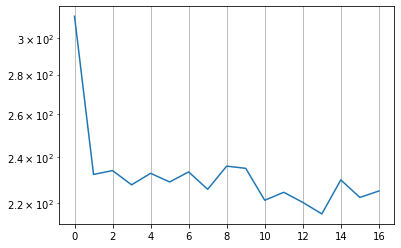

------------ 310 : 2.68s
loss:  tensor(24135.5645, device='cuda:0')
RVV:  tensor(4.4126, device='cuda:0')
logProp:  tensor(-148.4424, device='cuda:0')
------------ 320 : 2.82s
loss:  tensor(31875.4434, device='cuda:0')
RVV:  tensor(4.5861, device='cuda:0')
logProp:  tensor(-142.2077, device='cuda:0')
------------ 330 : 2.63s
loss:  tensor(31193.8848, device='cuda:0')
RVV:  tensor(4.3925, device='cuda:0')
logProp:  tensor(-150.3114, device='cuda:0')
------------ 340 : 2.71s
loss:  tensor(28868.4551, device='cuda:0')
RVV:  tensor(4.4665, device='cuda:0')
logProp:  tensor(-128.5835, device='cuda:0')
------------ 350 : 2.67s
loss:  tensor(31015.5527, device='cuda:0')
RVV:  tensor(4.3770, device='cuda:0')
logProp:  tensor(-144.2517, device='cuda:0')


KeyboardInterrupt: 

In [13]:
for _ in range(50):

    np.random.shuffle(allSamples)
        
    for it in range(IterPerEpoch):
        
        start = time.time()
        
        actor_optim.zero_grad()

        idxs = allSamples[it*BS:(it+1)*BS]

        machines = learning_machines[idxs]
        machines = np.concatenate([machines for _ in range(LS)])
        duration = learning_duration[idxs]
        duration = np.concatenate([duration for _ in range(LS)])

        rewards, logProbs, probs, actions_bare, actions, jobTime, _  = actor.forward(machines, duration)
        # Normalize the rewards
        rewards = rewards / 100.0

        y = torch.sum(logProbs,0)
        yyy = torch.sum(y,1)

    
        RVV = rewards.reshape([LS, BS])
        q = np.quantile(RVV.cpu().data.numpy(), 0.1, axis=0)
        RVV=RVV-torch.tensor(q).float().to(device)
        
        
        ID = (torch.mean(RVV,0) > 0.001)
        A = torch.sum(RVV,0)  
        B = 1./(0.01+torch.sum(RVV==0,0).float())
        RVV+=((RVV<=0)*ID).float()*(-A*B.float())
        RVV = RVV.view(-1)

        loss =  torch.mean(RVV * yyy)
        loss.backward(retain_graph=True)

        torch.nn.utils.clip_grad_norm_(actor.parameters(), 0.1)
        
        actor_optim.step()

        end = time.time()

        if it%10 == 0:
            print("------------", it, ": {0:.2f}s".format(end - start))
            print("loss: ", loss.data)
            print("RVV: ", torch.mean(rewards.float()).data)
            print("logProp: ", torch.mean(yyy).data)
            
            
        if it%50 == 0:
            
            AvgError, AvgDiff, DiffBest, _ = computeTestingError()
            TESTING_AvgError.append(AvgError)
            TESTING_AvgDiff.append(AvgDiff)
            
            print("DiffBest: ", np.mean(DiffBest))
            plt.semilogy(TESTING_AvgDiff)
            plt.grid(True)
            plt.show()
